In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

# PATH = '/content/drive/MyDrive/MITB/4 2023 Aug/ISSS609 Text Analytics and Applications/AnalyzingDisneylandReviews'
PATH = '..'

# Sentiment Analysis
https://www.kaggle.com/code/ganiesenov/sentiment-analysis-using-nltk-gensim-models

ABSA
* https://github.com/yangheng95/PyABSA/blob/v2/examples-v2/aspect_polarity_classification/Aspect_Sentiment_Classification.ipynb
* https://www.kaggle.com/code/phiitm/aspect-based-sentiment-analysis
* https://www.kaggle.com/code/nkitgupta/aspect-based-sentiment-analysis


TRY
https://blog.futuresmart.ai/aspect-based-sentiment-analysis-with-pyabsa-hugging-face

In [15]:
# Required libraries in Colab
! pip install transformers sentencepiece contractions num2words accelerate --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 50.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.2/125.2 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 44.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 61.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 27.8 MB/s eta 0:00:00


In [2]:
import sys

import numpy as np
import pandas as pd
import re
import math
from tqdm import tqdm, tqdm_pandas
from tqdm.autonotebook import tqdm
tqdm_pandas = tqdm.pandas()

import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_colwidth', None)
import plotly.express as px
from wordcloud import WordCloud

import nltk
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import PlaintextCorpusReader, stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer


from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.preprocessing import Normalizer, MinMaxScaler

import torch
# Check if GPU is available and use it if available, otherwise use CPU
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/var/folders/0g/_vw0ydz94_x5cpswktv47t9h0000gn/T/ipykernel_50062/1986343996.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
[nltk_data] Downloading package stopwords to /Users/sx/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/sx/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /Users/sx/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/sx/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/sx/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## 1. Load data

### 1.1 Import data

In [17]:
# Import data
df = pd.read_pickle(PATH+'/data/processed_reviews_with_ctry.pkl')

print(f"{len(df)} rows.")
df.head(5)

86032 rows.


,Review_ID,Sentence_ID,Review_Year,Review_Month,Branch,Rating,Review_Country,Review_Title,Review_Text
0,1,1,2023,9,Disneyland_Tokyo,5,Malaysia,Worth every penny and every minute,I visited Disney Land Tokyo with my family on a weekend night in December 2022.
1,1,2,2023,9,Disneyland_Tokyo,5,Malaysia,Worth every penny and every minute,We bought the evening entry that allowed us to enter the park after 3 p.m. at a discounted rate.
2,1,3,2023,9,Disneyland_Tokyo,5,Malaysia,Worth every penny and every minute,"We thought it was a great deal because we could still enjoy most of the attractions, parades, and shows without spending too much time or money."
3,1,4,2023,9,Disneyland_Tokyo,5,Malaysia,Worth every penny and every minute,We arrived at the park around 4 p.m. and headed straight to Tokyo Disneyland.
4,1,5,2023,9,Disneyland_Tokyo,5,Malaysia,Worth every penny and every minute,We were amazed by the beautiful decorations and the festive atmosphere.


### 1.2 Check length of strings

In [18]:
df["Review_Text_Length"] = df["Review_Text"].apply(lambda x : len(x.split()))

fig = px.histogram(df, x="Review_Text_Length",
                   title="Number of documents by number of characters",
                   hover_data=["Review_ID","Sentence_ID"],
                   marginal = "box")
fig.show()

### 1.3 Delete sentences with > 512 chars

In [19]:
MAX_SEQ_LENGTH = 512

In [20]:
# Reviews with sentences > MAX_SEQ_LENGTH
ids = df["Review_ID"][df["Review_Text_Length"] > MAX_SEQ_LENGTH]
ids = set(ids)
ids


{11008}

In [21]:
before = len(df)
print(f"Before deletion: {before} rows.")

df = df[~df["Review_ID"].isin(ids)].reset_index(drop = True)

after = len(df)
print(f"After deletion: {after} rows.")

deleted = before - after
print(f"Rows deleted: {deleted}")

Before deletion: 86032 rows.
After deletion: 86028 rows.
Rows deleted: 4


### 1.4 Vectorize
This incorporates the text preprocessing steps in `text_preprocessing.py`

In [22]:
sys.path.append(PATH+'/notebooks')
from text_preprocessing import text_preprocessing

# Setting list of stopwords
stop_words = set(stopwords.words('english'))
custom_stopwords = ['disneyland', 'park', 'disney', 'hongkong', 'hong', 'kong', 'mtr', 'orlando', 'shanghai','california','tokyo',
                    'japan', 'paris', 'would', 'could', 'place', 'visit', 'bring', 'following', 'follow', 'hk', 'hkg', 'themepark', 'day']
stop_words.update(custom_stopwords)

column_names = ["Review_Text"]  # each column will take around 30s to process

# For storing the TF-IDF vectors
tfidf_vectors_dict = {}

# For storing the features (words)
feature_names_dict = {}

for column_name in column_names:

    # Vectorize
    vectorizer = TfidfVectorizer(analyzer = lambda x: text_preprocessing(x,
                                                                         sub_ride = True,
                                                                         lemmatize = True,
                                                                         # stem = True,
                                                                         stopword_list = stop_words
                                                                        ),
                                max_df = 0.5,     # cannot appear in more than half of the docs
                                min_df = 2        # must appear in at least 2 docs
                                )

    X = vectorizer.fit_transform(df[column_name])
    tfidf_vectors_dict[f'{column_name}_tfidf'] = X

    feature_names = vectorizer.get_feature_names_out()
    feature_names_dict[f'{column_name}_features'] = feature_names

    print(f"### {column_name} ###")
    print("n_samples: %d, n_features: %d" % X.shape)
    print(f"features: {feature_names}")
    print()


    # Bag of Words
    df[f"{column_name}_BOW"] =  df[column_name].apply(lambda x : text_preprocessing(x,
                                                                                    sub_ride = True,
                                                                                    lemmatize = True,
                                                                                    # stem = True,
                                                                                    stopword_list = stop_words
                                                                                   )
                                                     )

df.head(5)

### Review_Text ###
n_samples: 86028, n_features: 8189
features: ['aa' 'aback' 'abandon' ... 'zoom' 'zootopia' 'zurg']



,Review_ID,Sentence_ID,Review_Year,Review_Month,Branch,Rating,Review_Country,Review_Title,Review_Text,Review_Text_Length,Review_Text_BOW
0,1,1,2023,9,Disneyland_Tokyo,5,Malaysia,Worth every penny and every minute,I visited Disney Land Tokyo with my family on a weekend night in December 2022.,15,"[land, family, weekend, night, december]"
1,1,2,2023,9,Disneyland_Tokyo,5,Malaysia,Worth every penny and every minute,We bought the evening entry that allowed us to enter the park after 3 p.m. at a discounted rate.,19,"[buy, evening, entry, allow, us, enter, three, discounted, rate]"
2,1,3,2023,9,Disneyland_Tokyo,5,Malaysia,Worth every penny and every minute,"We thought it was a great deal because we could still enjoy most of the attractions, parades, and shows without spending too much time or money.",26,"[think, great, deal, still, enjoy, attraction, parade, show, without, spend, much, time, money]"
3,1,4,2023,9,Disneyland_Tokyo,5,Malaysia,Worth every penny and every minute,We arrived at the park around 4 p.m. and headed straight to Tokyo Disneyland.,14,"[arrive, around, four, head, straight]"
4,1,5,2023,9,Disneyland_Tokyo,5,Malaysia,Worth every penny and every minute,We were amazed by the beautiful decorations and the festive atmosphere.,11,"[amaze, beautiful, decoration, festive, atmosphere]"


In [23]:
# Clean up Review_Text
df["Review_Text_Clean"] = df["Review_Text"].apply(lambda x : text_preprocessing(x,
                                                                                sub_ride = True,
                                                                                lemmatize = False,
                                                                                stopword_list = None
                                                                                ))
df["Review_Text_Clean"] = df["Review_Text_Clean"].apply(lambda x : ' '.join(x))

In [24]:
# Unpack BOW
df["Review_Text_BOW"] = df["Review_Text_BOW"].apply(lambda x : ' '.join(x))

In [25]:
# TF-IDF vectors for Review_Text
tfidf = tfidf_vectors_dict['Review_Text_tfidf']

tfidf

<86028x8189 sparse matrix of type '<class 'numpy.float64'>'
	with 618168 stored elements in Compressed Sparse Row format>

In [26]:
df.describe()

,Review_ID,Sentence_ID,Review_Year,Review_Month,Rating,Review_Text_Length
count,86028.000000,86028.000000,86028.000000,86028.000000,86028.000000,86028.000000
mean,7500.686102,43687.291417,2016.258427,6.515995,4.182778,17.406286
std,4604.073088,25218.629368,1.895863,3.426284,1.013136,14.288100
min,1.000000,1.000000,2013.000000,1.000000,1.000000,1.000000
25%,3494.000000,21853.750000,2015.000000,4.000000,4.000000,9.000000
50%,7134.000000,43675.500000,2016.000000,6.000000,4.000000,14.000000
75%,11717.000000,65535.250000,2018.000000,9.000000,5.000000,21.000000
max,15473.000000,87354.000000,2023.000000,12.000000,5.000000,458.000000


# 2. Exploring Pretrained Models

### 2.1 DistilBERT

**DistilBERT** is a smaller, lightweight model that is similar to BERT. It is trained to predict the same probabilities as BERT by introducing a triple loss -- a combination of:
1. Finding the same probabilities as the teacher model
2. Predicting the masked tokens correctly (but no next-sentence objective)
3. A cosine similarity between the hidden states of the student and the teacher model

Documentation: https://huggingface.co/docs/transformers/model_doc/distilbert

**Chosen implementation**: https://huggingface.co/lxyuan/distilbert-base-multilingual-cased-sentiments-student <br>
This model is trained on multilingual sentiments, and predicts 3 classes: "positive", "neutral", and "negative"

Preprocessing and tokenisation reference: https://huggingface.co/transformers/v4.4.2/preprocessing.html

In [28]:
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification

BATCH_SIZE = 32

In [18]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english",
                                          truncation=True,
                                          padding=True,
                                          max_length=MAX_SEQ_LENGTH
                                          )
model = AutoModelForSequenceClassification.from_pretrained("lxyuan/distilbert-base-multilingual-cased-sentiments-student")


# Initialise classifier
classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, device = DEVICE, batch_size=BATCH_SIZE)

In [22]:
distilBERT_preds = classifier.predict(df['Review_Text_Clean'].tolist())

print(distilBERT_preds[:5])


distilBERT_labels = []
for d in tqdm(distilBERT_preds):
  distilBERT_labels.append(d['label'])


# Append results to dataframe
df['distilBERT_results'] = distilBERT_preds
df['distilBERT_labels'] = distilBERT_labels


# save output as .pkl file
df.to_pickle(PATH+'/data/results_distilBERT.pkl')
print("Results have been saved.")

[{'label': 'positive', 'score': 0.5143187642097473}, {'label': 'negative', 'score': 0.7547488808631897}, {'label': 'negative', 'score': 0.5079590678215027}, {'label': 'positive', 'score': 0.5263603925704956}, {'label': 'negative', 'score': 0.5527709126472473}]


  0%|          | 0/86028 [00:00<?, ?it/s]

In [23]:
len(df)

86028

In [24]:
df.head(5)

,Review_ID,Sentence_ID,Review_Year,Review_Month,Branch,Rating,Review_Country,Review_Title,Review_Text,Review_Text_Length,Review_Text_BOW,Review_Text_Clean,distilBERT_results,distilBERT_labels
0,1,1,2023,9,Disneyland_Tokyo,5,Malaysia,Worth every penny and every minute,I visited Disney Land Tokyo with my family on a weekend night in December 2022.,15,land family weekend night december,i visited disney land tokyo with my family on a weekend night in december,"{'label': 'positive', 'score': 0.5143187642097473}",positive
1,1,2,2023,9,Disneyland_Tokyo,5,Malaysia,Worth every penny and every minute,We bought the evening entry that allowed us to enter the park after 3 p.m. at a discounted rate.,19,buy evening entry allow us enter three discounted rate,we bought the evening entry that allowed us to enter the park after three at a discounted rate,"{'label': 'negative', 'score': 0.7547488808631897}",negative
2,1,3,2023,9,Disneyland_Tokyo,5,Malaysia,Worth every penny and every minute,"We thought it was a great deal because we could still enjoy most of the attractions, parades, and shows without spending too much time or money.",26,think great deal still enjoy attraction parade show without spend much time money,we thought it was a great deal because we could still enjoy most of the attractions parades and shows without spending too much time or money,"{'label': 'negative', 'score': 0.5079590678215027}",negative
3,1,4,2023,9,Disneyland_Tokyo,5,Malaysia,Worth every penny and every minute,We arrived at the park around 4 p.m. and headed straight to Tokyo Disneyland.,14,arrive around four head straight,we arrived at the park around four and headed straight to tokyo disneyland,"{'label': 'positive', 'score': 0.5263603925704956}",positive
4,1,5,2023,9,Disneyland_Tokyo,5,Malaysia,Worth every penny and every minute,We were amazed by the beautiful decorations and the festive atmosphere.,11,amaze beautiful decoration festive atmosphere,we were amazed by the beautiful decorations and the festive atmosphere,"{'label': 'negative', 'score': 0.5527709126472473}",negative


### 2.2 Twitter-roBERTa-base for Sentiment Analysis

This is a RoBERTa-base model trained on ~124M tweets from January 2018 to December 2021, and finetuned for sentiment analysis with the TweetEval benchmark.

**Chosen implementation**: https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest

In [29]:
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest",
                                          truncation=True,
                                          padding=True,
                                          max_length=MAX_SEQ_LENGTH
                                          )
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")


# Initialise classifier
classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, device = DEVICE, batch_size=BATCH_SIZE)


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [30]:
roBERTa_preds = classifier.predict(df['Review_Text_Clean'].tolist())

print(roBERTa_preds[:5])


roBERTa_labels = []
for d in tqdm(roBERTa_preds):
  roBERTa_labels.append(d['label'])


# Append results to dataframe
df['roBERTa_results'] = roBERTa_preds
df['roBERTa_labels'] = roBERTa_labels


# save output as .pkl file
df.to_pickle(PATH+'/data/results_roBERTa.pkl')
print("Results have been saved.")

[{'label': 'neutral', 'score': 0.5582375526428223}, {'label': 'neutral', 'score': 0.7489202618598938}, {'label': 'positive', 'score': 0.9498160481452942}, {'label': 'neutral', 'score': 0.6469711661338806}, {'label': 'positive', 'score': 0.9857492446899414}]


  0%|          | 0/86028 [00:00<?, ?it/s]

# 3. Model Evaluation

In [8]:
# Load evaluation data
df_eval = pd.read_excel(PATH+'/data/df_eval.xlsx')
# Convert Sentiment col to lowercase
df_eval['Sentiment']=df_eval['Sentiment'].apply(lambda x: x.lower())

# Load predictions
df_distilBERT = pd.read_pickle(PATH+'/data/results_distilBERT.pkl')
df_roBERTa = pd.read_pickle(PATH+'/data/results_roBERTa.pkl')


# Double check if the sentences are the same
idx = 1764

print(f"distilBERT preds: {df_distilBERT.loc[df_distilBERT['Sentence_ID']==idx, 'Review_Text']}")
print(f"roBERTa preds: {df_roBERTa.loc[df_roBERTa['Sentence_ID']==idx, 'Review_Text']}")
print(f"eval: {df_eval.loc[df_eval['Sentence_ID']==idx, 'Review_Text']}")


/Users/sx/miniconda3/envs/isss609/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


distilBERT preds: 1720    Parade was very good.I’d recommend arriving early even if you’ve booked tickets because the queue to get in is huge, even on quiet days.
Name: Review_Text, dtype: object
roBERTa preds: 1720    Parade was very good.I’d recommend arriving early even if you’ve booked tickets because the queue to get in is huge, even on quiet days.
Name: Review_Text, dtype: object
eval: 3    Parade was very good.I‚Äôd recommend arriving early even if you‚Äôve booked tickets because the queue to get in is huge, even on quiet days.
Name: Review_Text, dtype: object


In [9]:
# Merge with predictions
df_merged = pd.merge(df_distilBERT, df_eval[['Sentence_ID','Sentiment']], how='left', on=['Sentence_ID'])
df_merged = pd.merge(df_merged, df_roBERTa[['Sentence_ID','roBERTa_labels']], how='left', on=['Sentence_ID'])

# Rename actual column
df_merged.rename(columns={"Sentiment": "Actual_Sentiment"}, inplace=True)

df_merged.head(3)

,Review_ID,Sentence_ID,Review_Year,Review_Month,Branch,Rating,Review_Country,Review_Title,Review_Text,Review_Text_Length,Review_Text_BOW,Review_Text_Clean,distilBERT_results,distilBERT_labels,Actual_Sentiment,roBERTa_labels
0,1,1,2023,9,Disneyland_Tokyo,5,Malaysia,Worth every penny and every minute,I visited Disney Land Tokyo with my family on a weekend night in December 2022.,15,land family weekend night december,i visited disney land tokyo with my family on a weekend night in december,"{'label': 'positive', 'score': 0.5143187642097473}",positive,NaN,neutral
1,1,2,2023,9,Disneyland_Tokyo,5,Malaysia,Worth every penny and every minute,We bought the evening entry that allowed us to enter the park after 3 p.m. at a discounted rate.,19,buy evening entry allow us enter three discounted rate,we bought the evening entry that allowed us to enter the park after three at a discounted rate,"{'label': 'negative', 'score': 0.7547488808631897}",negative,NaN,neutral
2,1,3,2023,9,Disneyland_Tokyo,5,Malaysia,Worth every penny and every minute,"We thought it was a great deal because we could still enjoy most of the attractions, parades, and shows without spending too much time or money.",26,think great deal still enjoy attraction parade show without spend much time money,we thought it was a great deal because we could still enjoy most of the attractions parades and shows without spending too much time or money,"{'label': 'negative', 'score': 0.5079590678215027}",negative,NaN,positive


In [35]:
# Extract the rows for evaluation
eval = df_merged[["Review_Text","distilBERT_labels","roBERTa_labels","Actual_Sentiment"]].dropna()

y_pred_roBERTa = eval["roBERTa_labels"].to_list()
y_pred_distilBERT = eval["distilBERT_labels"].to_list()
y_true = eval["Actual_Sentiment"].to_list()

In [36]:
# Show classification report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix

# Define function to evaluate
def evaluate(y_true, y_pred):

  # List the sentiment classes in the order we want them to appear
  senti_labels = ["positive", "neutral", "negative"]

  # Classification report
  print(classification_report(y_true, y_pred))

  # Confusion matrix
  cm = confusion_matrix(y_true, y_pred, labels=senti_labels)

  ax= plt.subplot()
  sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #ftm='g' to disable scientific notation

  # labels, title and ticks
  ax.set_title('Confusion Matrix');
  ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
  ax.xaxis.set_ticklabels(senti_labels)
  ax.yaxis.set_ticklabels(senti_labels)
  plt.show()

## 3.1 Evaluating results of distilBERT

              precision    recall  f1-score   support

    negative       0.23      0.44      0.30       179
     neutral       0.33      0.00      0.01       226
    positive       0.47      0.55      0.51       361

    accuracy                           0.36       766
   macro avg       0.34      0.33      0.27       766
weighted avg       0.37      0.36      0.31       766



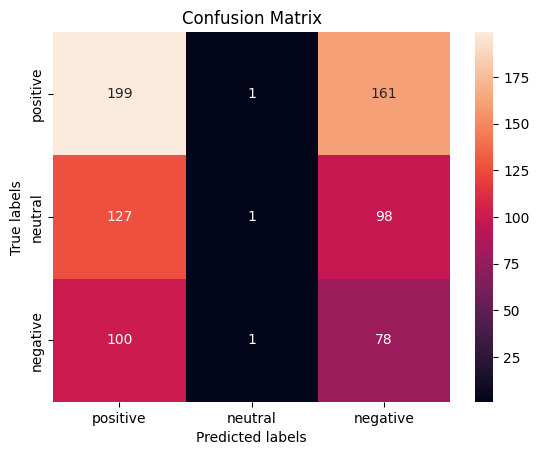

In [37]:
evaluate(y_true, y_pred_distilBERT)

## 3.2 Evaluating results of roBERTa

              precision    recall  f1-score   support

    negative       0.77      0.50      0.61       179
     neutral       0.53      0.70      0.60       226
    positive       0.81      0.79      0.80       361

    accuracy                           0.69       766
   macro avg       0.70      0.66      0.67       766
weighted avg       0.72      0.69      0.70       766



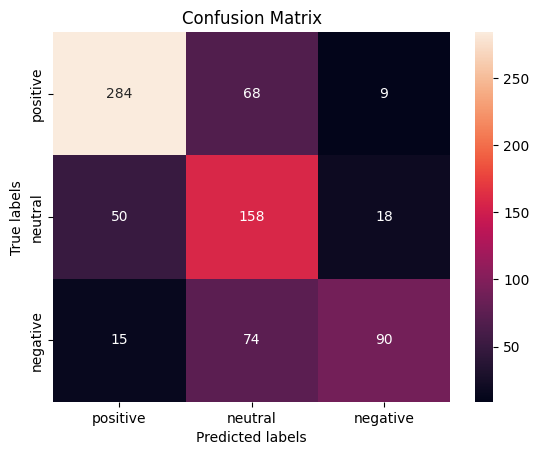

In [38]:
evaluate(y_true, y_pred_roBERTa)

In [14]:
# Let's examine visually the ones that don't match
condition = (eval['distilBERT_labels'] != eval['Actual_Sentiment'])
eval[condition]


,Review_Text,distilBERT_labels,Actual_Sentiment
1870,It's pretty close the one in the US though most shows are in Japanese.,negative,neutral
1872,**though character greeting is a bit all-over the place...the rides and organization is superb!,negative,positive
2769,Cast Member service is truly excellent.,negative,positive
2771,"If you have young ones (especially little girls), I HIGHLY suggest the Queen of Hearts Banquet Hall for lunch or dinner.",negative,positive
2774,Also be on the lookout for unique collectible popcorn buckets throughout the various flavored popcorn stations.,positive,neutral
...,...,...,...
85395,"I felt like I was transported back to my childhood days where I dreamt of meeting the princesses, mickey and his friends.. the fireworks display at night was worth the wait.. no regrets spending my time there.. will definitely save up to visit Disney again.",negative,positive
85396,This time I hope it will be the Disney world in Orlando..,negative,neutral
85834,From the opening of gates up to closing.,positive,neutral
85839,"Themed areas for extreme rides is in grizzly gulch, toy stroy land, adventureland and tomorrowland.",negative,neutral


# 4. Include topics from topic modelling

In [19]:
# Load the .pkl output from topic modelling
tm = pd.read_pickle(PATH+"/data/processed_reviews_w_topics.pkl")

# Append the predicted sentiment labels to tm
tm = pd.merge(tm, df_merged[['Sentence_ID', 'Actual_Sentiment', 'distilBERT_labels','roBERTa_labels']], how = 'inner', on=['Sentence_ID'])
print(f"Output df has {len(tm)} rows.")

# Export to csv
tm.to_csv(PATH+"/data/topic_sentiment_transformers.csv", index = False)

Output df has 86028 rows.


In [20]:
tm

,Review_ID,Sentence_ID,Review_Year,Review_Month,Branch,Rating,Review_Country,Review_Title,Review_Text,Review_Text_BOW,...,Food_and_Merchandise,Rides_and_Attractions,Entertainment_and_Shows,Accessibility_and_Convenience,Facilities_and_Environment,Pricing_and_Value,Topic,Actual_Sentiment,distilBERT_labels,roBERTa_labels
0,1,1,2023,9,Disneyland_Tokyo,5,Malaysia,Worth every penny and every minute,I visited Disney Land Tokyo with my family on a weekend night in December 2022.,"[land, family, weekend, night, december]",...,0.000000,0.00000,0.000000,0.0,0.0,0.0,None,NaN,positive,neutral
1,1,2,2023,9,Disneyland_Tokyo,5,Malaysia,Worth every penny and every minute,We bought the evening entry that allowed us to enter the park after 3 p.m. at a discounted rate.,"[buy, evening, entry, allow, us, enter, three, discounted, rate]",...,0.000000,0.00000,0.000000,0.0,0.0,1.0,[Pricing_and_Value],NaN,negative,neutral
2,1,3,2023,9,Disneyland_Tokyo,5,Malaysia,Worth every penny and every minute,"We thought it was a great deal because we could still enjoy most of the attractions, parades, and shows without spending too much time or money.","[think, great, deal, still, enjoy, attraction, parade, show, without, spend, much, time, money]",...,0.145672,0.34486,0.509468,0.0,0.0,0.0,[Entertainment_and_Shows],NaN,negative,positive
3,1,4,2023,9,Disneyland_Tokyo,5,Malaysia,Worth every penny and every minute,We arrived at the park around 4 p.m. and headed straight to Tokyo Disneyland.,"[arrive, around, four, head, straight]",...,0.000000,0.00000,0.000000,0.0,0.0,0.0,None,NaN,positive,neutral
4,1,5,2023,9,Disneyland_Tokyo,5,Malaysia,Worth every penny and every minute,We were amazed by the beautiful decorations and the festive atmosphere.,"[amaze, beautiful, decoration, festive, atmosphere]",...,0.000000,0.00000,0.000000,0.0,0.0,0.0,[Atmosphere_and_Theme],NaN,negative,positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86023,15473,87350,2013,1,Disneyland_HongKong,3,Philippines,HKG Disneyland needs crowd control!,"If you have been to HKG you know that people do not respect your personal space...getting bumped, pushed, shoved is common.","[know, people, respect, personal, space, get, bump, push, shove, common]",...,0.000000,0.00000,0.000000,0.0,0.0,0.0,[Capacity_and_Queue_Management],NaN,negative,negative
86024,15473,87351,2013,1,Disneyland_HongKong,3,Philippines,HKG Disneyland needs crowd control!,HKG Disney is no different.,[different],...,0.000000,0.00000,0.000000,0.0,0.0,0.0,None,NaN,positive,neutral
86025,15473,87352,2013,1,Disneyland_HongKong,3,Philippines,HKG Disneyland needs crowd control!,However I expect Disney to properly manage the crowds specially since we bring our young children there.,"[however, expect, properly, manage, crowd, specially, since, young, child]",...,0.000000,0.00000,0.000000,0.0,0.0,0.0,[Capacity_and_Queue_Management],NaN,positive,neutral
86026,15473,87353,2013,1,Disneyland_HongKong,3,Philippines,HKG Disneyland needs crowd control!,"Announcements in Chinese should be made stating that there are enough seats inside the venues to accommodate everyone, that there are elderly people and children in the crowd that can get hurt or trampled.","[announcement, chinese, make, state, enough, seat, inside, venue, accommodate, everyone, elderly, people, child, crowd, get, hurt, trample]",...,0.281258,0.00000,0.000000,0.0,0.0,0.0,[Capacity_and_Queue_Management],NaN,positive,neutral
